# Module install and import

In [1]:
# !pip install shap

In [2]:
import shap

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
def recall5(answer_df, submission_df):
    """
    Calculate recall@5 for given dataframes.

    Parameters:
    - answer_df: DataFrame containing the ground truth
    - submission_df: DataFrame containing the predictions

    Returns:
    - recall: Recall@5 value
    """

    primary_col = answer_df.columns[0]
    secondary_col = answer_df.columns[1]

    # Check if each primary_col entry has exactly 5 secondary_col predictions
    prediction_counts = submission_df.groupby(primary_col).size()
    if not all(prediction_counts == 5):
        raise ValueError(f"Each {primary_col} should have exactly 5 {secondary_col} predictions.")


    # Check for NULL values in the predicted secondary_col
    if submission_df[secondary_col].isnull().any():
        raise ValueError(f"Predicted {secondary_col} contains NULL values.")

    # Check for duplicates in the predicted secondary_col for each primary_col
    duplicated_preds = submission_df.groupby(primary_col).apply(lambda x: x[secondary_col].duplicated().any())
    if duplicated_preds.any():
        raise ValueError(f"Predicted {secondary_col} contains duplicates for some {primary_col}.")


    # Filter the submission dataframe based on the primary_col present in the answer dataframe
    submission_df = submission_df[submission_df[primary_col].isin(answer_df[primary_col])]

    # For each primary_col, get the top 5 predicted secondary_col values
    top_5_preds = submission_df.groupby(primary_col).apply(lambda x: x[secondary_col].head(5).tolist()).to_dict()

    # Convert the answer_df to a dictionary for easier lookup
    true_dict = answer_df.groupby(primary_col).apply(lambda x: x[secondary_col].tolist()).to_dict()
    # answer_df가 val입니다.


    individual_recalls = []
    for key, val in true_dict.items():
        if key in top_5_preds:
            correct_matches = len(set(true_dict[key]) & set(top_5_preds[key]))  # 두 set에 공통으로 있는것의 길이이다.
            # true_dict는 정답이고, pred은 예측값이다.  근데 정답은 1개만 주어졌으니까 correct_matches는 최대 1이다.
            individual_recall = correct_matches / min(len(val), 5) # 공정한 평가를 가능하게 위하여 분모(k)를 'min(len(val), 5)' 로 설정함
            # min(len(val), 5)는 입력인자 2개중 더 작은값을 내보냄
            individual_recalls.append(individual_recall)
            # 그래서 정답을 맞추면 0.2라는 값이 저장된다.

# 그거의 평균값
    recall = np.mean(individual_recalls)
    return recall

In [4]:
# Basic Module
import numpy as np # numpy
import pandas as pd # pandas

from tqdm.auto import tqdm

import lightgbm as lgb # LightGBM Model
from lightgbm import LGBMClassifier, plot_importance
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split # train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from collections import defaultdict

In [5]:
# Data Visualization Module
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # 고해상도 설정
mpl.rc('axes', unicode_minus=False)
plt.style.use('fivethirtyeight')
plt.ion()
import seaborn as sns

In [6]:
# Data Path
try:
    from google.colab import drive
    drive.mount('/content/drive')
    # path 정보
    default_path = '/content/drive/MyDrive/dacon/csv/'
    result_input_path='/content/drive/MyDrive/dacon/result/LightGBM'
    print("노트북은 Google Colab에서 실행 중입니다.")

except:
    dir_path = './csv/'
    result_input_path='./result/'
    print("노트북은 Google Colab이 아닌 환경에서 실행 중입니다.")

노트북은 Google Colab이 아닌 환경에서 실행 중입니다.


In [7]:
# submission data save
from datetime import datetime
import os # os

import csv # csv

rusult_filename='ms_submission' + datetime.today().strftime('%m%d') # 파일명 고정값
ruslut_file_ext='.csv' # 파일 형식

submission_csv = result_input_path+'%s%s' %(rusult_filename,ruslut_file_ext)
uniq = 1
while os.path.exists(submission_csv):  # 동일한 파일명이 존재할 때
    submission_csv = result_input_path + '%s_%d%s' % (rusult_filename, uniq, ruslut_file_ext) # 파일명(1) 파일명(2)...
    uniq += 1

In [8]:
import warnings # warnings ignore
warnings.filterwarnings('ignore')
import logging # log ignore
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# Global variable

In [9]:
# 데이터 고정 변수
random_state = 42

# Data Load and preprocessing

In [10]:
default_path= dir_path

# history data
ori_apply = pd.read_csv(default_path+'apply_train.csv') # 지원 이력

# resume data
ori_resume = pd.read_csv(default_path+'resume.csv') # 이력서 데이터
ori_certificate = pd.read_csv(default_path+'resume_certificate.csv') # 자격증 데이터
ori_education = pd.read_csv(default_path+'resume_education.csv') # 학력 데이터
ori_language = pd.read_csv(default_path+'resume_language.csv') # 언어 자격증 데이터

# recruitment data
ori_recruitment = pd.read_csv(default_path+'recruitment.csv') # 공고 데이터
ori_company = pd.read_csv(default_path+'company.csv')  # 기업 데이터

# submission
submission = pd.read_csv(default_path+'sample_submission.csv') # 지원결과(submission)

ori_apply.shape, ori_resume.shape, ori_certificate.shape, ori_education.shape, ori_language.shape, ori_recruitment.shape, ori_company.shape, submission.shape

((57946, 2),
 (8482, 13),
 (12975, 2),
 (8482, 14),
 (869, 4),
 (6695, 11),
 (2377, 4),
 (42410, 2))

In [11]:
resume_all= pd.read_csv(default_path+'resume.csv')
ori_resume = pd.read_csv(default_path+'resume.csv')


In [12]:
# # 모델이 있는 노트에서 다시 read_csv 하기 위해 출려
# recruit_all.to_csv(csv_path + "/recruit_all.csv" , index = False)

## ★apply_train negative sampling

In [13]:
ori_apply['target']=1

In [14]:
ori_apply

,resume_seq,recruitment_seq,target
0,U05833,R03838,1
1,U06456,R02144,1
2,U07807,R01877,1
3,U04842,R02463,1
4,U08336,R00112,1
...,...,...,...
57941,U02270,R03430,1
57942,U02640,R04987,1
57943,U08238,R01342,1
57944,U01296,R06363,1


In [15]:
import random

class LoadData(object):

  def __init__(self, dataset):
    self.dataset = dataset

    self.user_pool = set(self.dataset['resume_seq'].unique())
    self.item_pool = set(self.dataset['recruitment_seq'].unique())

    self.negatives = self.__sample_negative()

  def __sample_negative(self):
    """
    return alll negative items & sampled negative items
    """
    # interacted_recruitment_seq: 사용자별 지원한 공고리스트
    interact_status = self.dataset.groupby(['resume_seq'])['recruitment_seq'].apply(set).reset_index().rename(
        columns={'recruitment_seq':'interacted_recruitment_seq'}
    )
    # negative_recruitment_seq: 사용자별 지원하지 않은 공고리스트
    interact_status['negative_recruitment_seq'] = interact_status['interacted_recruitment_seq'].map(lambda x: self.item_pool - x)

    # 각 resume_seq별로 상호 작용한 recruitment_seq의 수만큼 네거티브 샘플을 생성
    interact_status['num_ng'] = interact_status['interacted_recruitment_seq'].apply(len)
    interact_status['negative_samples'] = interact_status.apply(lambda x: random.sample(list(x['negative_recruitment_seq']), x['num_ng']), axis=1)

    return interact_status[['resume_seq', 'negative_recruitment_seq', 'negative_samples', 'num_ng']]

# ori_apply은 데이터셋이라고 가정합니다.


In [16]:
loaddata = LoadData(ori_apply)

In [17]:
loaddata.dataset

,resume_seq,recruitment_seq,target
0,U05833,R03838,1
1,U06456,R02144,1
2,U07807,R01877,1
3,U04842,R02463,1
4,U08336,R00112,1
...,...,...,...
57941,U02270,R03430,1
57942,U02640,R04987,1
57943,U08238,R01342,1
57944,U01296,R06363,1


In [18]:
# sorted_df = loaddata.dataset.sort_values(by='resume_seq', ascending=True)
# sorted_df = sorted_df.reset_index(drop=True)
# sorted_df

In [19]:
loaddata.negatives.head()

,resume_seq,negative_recruitment_seq,negative_samples,num_ng
0,U00001,"{R01148, R03166, R05665, R01187, R02484, R0497...","[R01672, R02049, R00450, R00232]",4
1,U00002,"{R01148, R03166, R05665, R01187, R02484, R0497...","[R06000, R03828, R03365, R00171, R04538, R0654...",8
2,U00003,"{R01148, R03166, R05665, R01187, R02484, R0497...","[R01309, R03122, R02488]",3
3,U00004,"{R01148, R03166, R05665, R01187, R02484, R0497...","[R00991, R01727, R05236, R05922, R00912, R0440...",17
4,U00005,"{R01148, R03166, R05665, R01187, R02484, R0497...","[R02819, R03093, R00071]",3


In [20]:
def add_negative_items(data, negative):
    negative = negative[['resume_seq', 'negative_samples']].explode('negative_samples').rename(
        columns={'negative_samples':'recruitment_seq'}
    )
    negative['target'] = 0
    return pd.concat([data, negative], axis=0)

In [21]:
ori_apply_edited = add_negative_items(loaddata.dataset, loaddata.negatives)
apply_negative = ori_apply_edited.sort_values(by='resume_seq', ascending=True) # 오름차순 정렬
apply_negative = apply_negative.reset_index(drop=True) # 인덱스 재설정

In [22]:
apply_negative

,resume_seq,recruitment_seq,target
0,U00001,R00232,0
1,U00001,R01672,0
2,U00001,R02049,0
3,U00001,R05210,1
4,U00001,R00450,0
...,...,...,...
115887,U08482,R00767,0
115888,U08482,R06282,1
115889,U08482,R03743,1
115890,U08482,R03633,1


## ★user_similarity

In [23]:
# 사용자-아이템 행렬 생성: 구직자가 해당 채용 공고에 지원했으면 1, 아니면 0으로 설정
user_item_matrix = ori_apply.groupby(['resume_seq', 'recruitment_seq']).size().unstack(fill_value=0)
user_item_matrix[user_item_matrix > 1] = 1

# 사용자 간의 유사성 계산
user_similarity = cosine_similarity(user_item_matrix)

# 추천 점수 계산
user_predicted_scores = user_similarity.dot(user_item_matrix) / np.array([np.abs(user_similarity).sum(axis=1)]).T

In [24]:
user_similarity = cosine_similarity(user_item_matrix)

In [25]:
pd.DataFrame(user_similarity ).sort_values(by=2)

,0,1,2,3,4,5,6,7,8,9,...,8472,8473,8474,8475,8476,8477,8478,8479,8480,8481
0,1.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5659,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5658,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5657,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5656,0.25,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7000,0.00,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221,0.00,0.0,0.408248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1989,0.00,0.0,0.408248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8208,0.00,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
recommendations = {}

for idx, user in enumerate(tqdm(user_item_matrix.index, desc="Processing Users")):
    # 해당 사용자의 추천 점수 (높은 점수부터 정렬)
    sorted_job_indices = user_predicted_scores[idx].argsort()[::-1]
    # 상위 500개 추출
    recommended_jobs = [job for job in user_item_matrix.columns[sorted_job_indices]][:100]

    recommendations[str(user)] = recommended_jobs

Processing Users:   0%|          | 0/8482 [00:00<?, ?it/s]

이후계획
1. resume_seq, recruitment_seq로 피쳐 조인 -> 이후에 파일 저장하여 공유
2. 두 seq는 drop하고 train/test DF 생성 -> 교차검증
3. DF로 모델 학습
4. 각 resume_seq별로 전체 recruitment_seq의 확률 계산
5. 계산된 확률이 가장 높은 값으로 리스트화 하여 정리



이후계획
1. resume_seq, recruitment_seq로 피쳐 조인 -> 이후에 파일 저장하여 공유
2. 두 seq는 drop하고 train/test DF 생성 -> 교차검증
3. DF로 모델 학습
4. 각 resume_seq별로 전체 recruitment_seq의 확률 계산
5. 계산된 확률이 가장 높은 값으로 리스트화 하여 정리





```
# 코드로 형식 지정됨
```

#  1.resume_seq, recruitment_seq를 이용해 피쳐를 넣어 데이터프레임 생성


In [27]:
# # 본인만의 resume_all 파일이 있다면 아래에서 이름만 변경해주시면 됩니다
# resume_all = pd.read_pickle(default_path+'resume_all_m.pkl')
# recruit_all = pd.read_pickle(default_path+'recruit_all_m.pkl')

In [28]:
resume_all = pd.read_csv(default_path+'resume_all_min.csv')
recruit_all = pd.read_csv(default_path+'recruit_all_min.csv')

In [29]:
resume_all['career'] = resume_all['career'].map({
    '신입': '1',
    '1~3년': '2',
    '4~6년': '3',
    '7~9년': '4',
    '10~15년': '5',
    '16년~20년': '6',
    '21년 이상': '7'})

In [30]:
resume_all['career'] = resume_all['career'].astype('category')


In [31]:
resume = resume_all.copy()
recruitment = recruit_all.copy()
apply = ori_apply.copy()
df = apply_negative.copy()

In [32]:
# 전체 컬럼을 res_col로 했습니다. 이부분도 수정가능
res_col=list(resume.columns)

In [33]:
rec_col= list(recruitment.columns)

In [34]:
len(list(resume.nunique(0)))

35

In [35]:
desired_dtype = 'int64'  # 여기에 찾고자 하는 Dtype을 입력하세요

columns_with_desired_dtype = resume.select_dtypes(include=[desired_dtype]).columns.tolist()
print(columns_with_desired_dtype)

['reg_date', 'updated_date', 'degree', 'graduate_date', 'job_code_seq1', 'career_month', 'career_job_code', 'hischool_type_seq', 'hischool_special_type', 'hischool_nation', 'hischool_gender', 'hischool_location_seq', 'univ_type_seq1', 'univ_type_seq2', 'univ_transfer', 'univ_location', 'univ_major_type', 'univ_score', 'job', 'certificate_cnt', 'num_ng', 'task1', 'task2', 'task3', 'task4', 'task5', 'task6', 'task7']


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115892 entries, 0 to 115891
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   resume_seq       115892 non-null  object
 1   recruitment_seq  115892 non-null  object
 2   target           115892 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


In [37]:
recruitment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6695 entries, 0 to 6694
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   recruitment_seq        6695 non-null   object 
 1   address_seq1           6695 non-null   float64
 2   address_seq2           6695 non-null   float64
 3   address_seq3           6695 non-null   float64
 4   career_end             6695 non-null   int64  
 5   career_start           6695 non-null   int64  
 6   education              6695 non-null   int64  
 7   major_task             6695 non-null   int64  
 8   qualifications         6695 non-null   int64  
 9   text_keyword           6695 non-null   int64  
 10  check_box_2507         6695 non-null   int64  
 11  check_box_2707         6695 non-null   int64  
 12  check_box_2810         6695 non-null   int64  
 13  check_box_2204         6695 non-null   int64  
 14  check_box_2205         6695 non-null   int64  
 15  chec

In [38]:
resume.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8482 entries, 0 to 8481
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   resume_seq               8482 non-null   object  
 1   reg_date                 8482 non-null   int64   
 2   updated_date             8482 non-null   int64   
 3   degree                   8482 non-null   int64   
 4   graduate_date            8482 non-null   int64   
 5   hope_salary              8482 non-null   float64 
 6   last_salary              8482 non-null   float64 
 7   job_code_seq1            8482 non-null   int64   
 8   career_month             8482 non-null   int64   
 9   career_job_code          8482 non-null   int64   
 10  hischool_type_seq        8482 non-null   int64   
 11  hischool_special_type    8482 non-null   int64   
 12  hischool_nation          8482 non-null   int64   
 13  hischool_gender          8482 non-null   int64   
 14  hischool

In [39]:
resume

,resume_seq,reg_date,updated_date,degree,graduate_date,hope_salary,last_salary,job_code_seq1,career_month,career_job_code,...,career,num_ng,user_preferred_location,task1,task2,task3,task4,task5,task6,task7
0,U00001,19,1,4,1,1.0,1.0,7,0,4,...,1,4,3.0,0,2,0,2,0,0,0
1,U00002,20,3,4,1,0.0,0.0,7,73,1,...,3,8,3.0,0,8,0,0,0,0,0
2,U00003,18,6,4,1,0.0,0.0,7,113,4,...,4,3,3.0,0,3,0,0,0,0,0
3,U00004,17,3,4,1,0.0,0.0,7,27,4,...,1,17,3.0,0,16,0,0,1,0,0
4,U00005,20,3,4,1,0.0,0.0,7,0,4,...,1,3,3.0,0,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8477,U08478,20,2,4,2,0.0,2.0,7,60,4,...,2,2,3.0,0,2,0,0,0,0,0
8478,U08479,16,6,3,1,2.0,2.0,7,59,3,...,2,6,3.0,0,6,0,0,0,0,0
8479,U08480,19,5,4,1,0.0,0.0,4,0,4,...,1,2,3.0,0,2,0,0,0,0,0
8480,U08481,20,10,4,0,0.0,2.0,7,8,4,...,1,3,3.0,0,3,0,0,0,0,0


In [40]:
# 범주화할 컬럼 지정해줘야합니다.
# 두번째 set에는 범주화하지 않을 column들 넣어주시면 됩니다.
resume_category_cols = list(set(resume.columns) - set(['resume_seq','career_month', 'certificate_cnt',
        'task1','task2','task3','task4','task5','task6','task7']))
recruitment_category_cols = list(set(recruitment.columns) - set(['recruitment_seq','career_end','career_start',
        'check_box_keyword_cnt','recruit_pop']))
for col in resume_category_cols:
    resume[col] = resume[col].astype('category')
for col in recruitment_category_cols:
    recruitment[col] = recruitment[col].astype('category')
desired_dtype = 'category'
res_cate_col = resume.select_dtypes(include=[desired_dtype]).columns.tolist()
res_no_cate = list(set(resume.columns) - set(resume_category_cols))
rec_cate_col = recruitment.select_dtypes(include=[desired_dtype]).columns.tolist()
rec_no_cate = list(set(recruitment.columns) - set(recruitment_category_cols))

import category_encoders as ce

res_category = resume[res_cate_col]
rec_category = recruitment[rec_cate_col]

_resume_encoded = pd.DataFrame()
_recruit_encoded = pd.DataFrame()

for col in res_cate_col:
  _encoder = ce.OneHotEncoder(use_cat_names=True)
  _encoder.fit(res_category[col])
  _encoded = _encoder.transform(res_category[col])
  _resume_encoded = pd.concat([_resume_encoded, _encoded], axis=1)

for col in rec_cate_col:
  _encoder = ce.OneHotEncoder(use_cat_names=True)
  _encoder.fit(rec_category[col])
  _encoded = _encoder.transform(rec_category[col])
  _recruit_encoded = pd.concat([_recruit_encoded, _encoded], axis=1)
# concat해야함
resume = pd.concat([resume[res_no_cate], _resume_encoded], axis=1)
recruitment = pd.concat([recruitment[rec_no_cate], _recruit_encoded], axis=1)

# 여기서 사용할 컬럼 지정해야함

In [41]:
# 뒤에 set에 사용 안할 featrue 넣으면 됩니다.
res_use_col = list(set(resume.columns) - set(['lang_exam_score']))
rec_use_col = list(set(recruitment.columns) - set(['address_seq2']))

In [42]:
# 이거 사용할 컬럼들 본인이 지정해야합니다.
# 민석님이 하신걸로 대체했습니다
resume_used_cols = res_use_col
recruitment_used_cols = rec_use_col

In [43]:
df = df.merge(resume[resume_used_cols], on = 'resume_seq', how = 'left')
df = df.merge(recruitment[recruitment_used_cols], on = 'recruitment_seq', how = 'left')
df = df.drop(columns=["recruitment_seq", "resume_seq"])
df

,target,reg_date_11.0,univ_type_seq2_12.0,job_code_seq1_3.0,num_ng_33.0,univ_type_seq2_2.0,univ_major_type_7.0,last_salary_5.0,hischool_nation_1.0,univ_score_1.0,...,major_task_8.0,check_box_2302_1.0,text_keyword_7.0,address_seq1_0.0,employee_500.0,employee_10.0,supply_kind_413.0,company_type_seq_7.0,employee_170.0,employee_2000.0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115887,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
115888,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
115889,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
115890,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115892 entries, 0 to 115891
Columns: 500 entries, target to employee_2000.0
dtypes: int64(500)
memory usage: 442.1 MB


In [45]:
X = df.drop("target", axis=1)
y = df["target"]

In [46]:
feature_names = X.columns

# 2.DF로 모델 학습(LightGBM)


In [47]:
n_iter=5
num_folds=5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)

In [48]:
# param_dist = {
# }

# fixed_params = {
#     "max_depth" : 8,
#     "learning_rate": 0.01,
#     "boosting_type" : "GOSS",
#     "max_cat_threshold" : 32,
#     "num_leaves" : 150,
#     "force_row_wise": True,
# }

# # Create the LGBMClassifier with fixed parameters
# model = LGBMClassifier(random_state=random_state, **fixed_params)

# rs = RandomizedSearchCV(model, param_distributions=param_dist, scoring='roc_auc', n_iter=n_iter, n_jobs=-1, cv=kf, verbose=0).fit(X, y)
# print("Best ROC AUC Score:", rs.best_score_)
# print("Best Parameters:", rs.best_params_)

In [49]:
# table = pd.pivot_table(pd.DataFrame(rs.cv_results_),
#     values='mean_test_score', index='param_feature_fraction',
#                        columns='param_max_depth')

# sns.heatmap(table)

In [50]:
best_params = {
    "max_depth" : 9,
    "learning_rate": 0.1,
    'verbose':-1,
    "n_estimators" : 1000,
    'num_leaves': 40,

    #"boosting_type" : "GOSS",
    #"max_cat_threshold" : 32,
    #"num_leaves" : 150,
    #"force_row_wise": True,
}
best_model = lgb.LGBMClassifier(**best_params, random_state=random_state)

In [51]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
auc_lst=[]
n_iter=0

# cross_validation
for train_index, valid_index in skf.split(X, y):
    n_iter += 1
    # 학습용, 검증용 데이터 구성
    tr_x, valid_x = X.iloc[train_index], X.iloc[valid_index]
    tr_y, valid_y = y.iloc[train_index], y.iloc[valid_index]

    # 학습
    best_model.fit(tr_x, tr_y)
    #valid_pred = best_model.predict(valid_x) # 예측값
    valid_pred_proba = best_model.predict_proba(valid_x)[:,1]

    # 평가
    fpr, tpr, thresholds = roc_curve(valid_y, valid_pred_proba)

    valid_auc = auc(fpr, tpr)
    auc_lst.append(valid_auc)
    print(f'{n_iter} 번째 Stratified Stratified K-Fold 정확도: {valid_auc}')

print('-'*50)
print(f'교차 검증 auc: {np.mean(auc_lst)}')


1 번째 Stratified Stratified K-Fold 정확도: 0.9002033257117832
2 번째 Stratified Stratified K-Fold 정확도: 0.8993160930104571
3 번째 Stratified Stratified K-Fold 정확도: 0.8932587957815783
4 번째 Stratified Stratified K-Fold 정확도: 0.8971120946491602
5 번째 Stratified Stratified K-Fold 정확도: 0.895051894636087
--------------------------------------------------
교차 검증 auc: 0.8969884407578131


## Features Importance

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

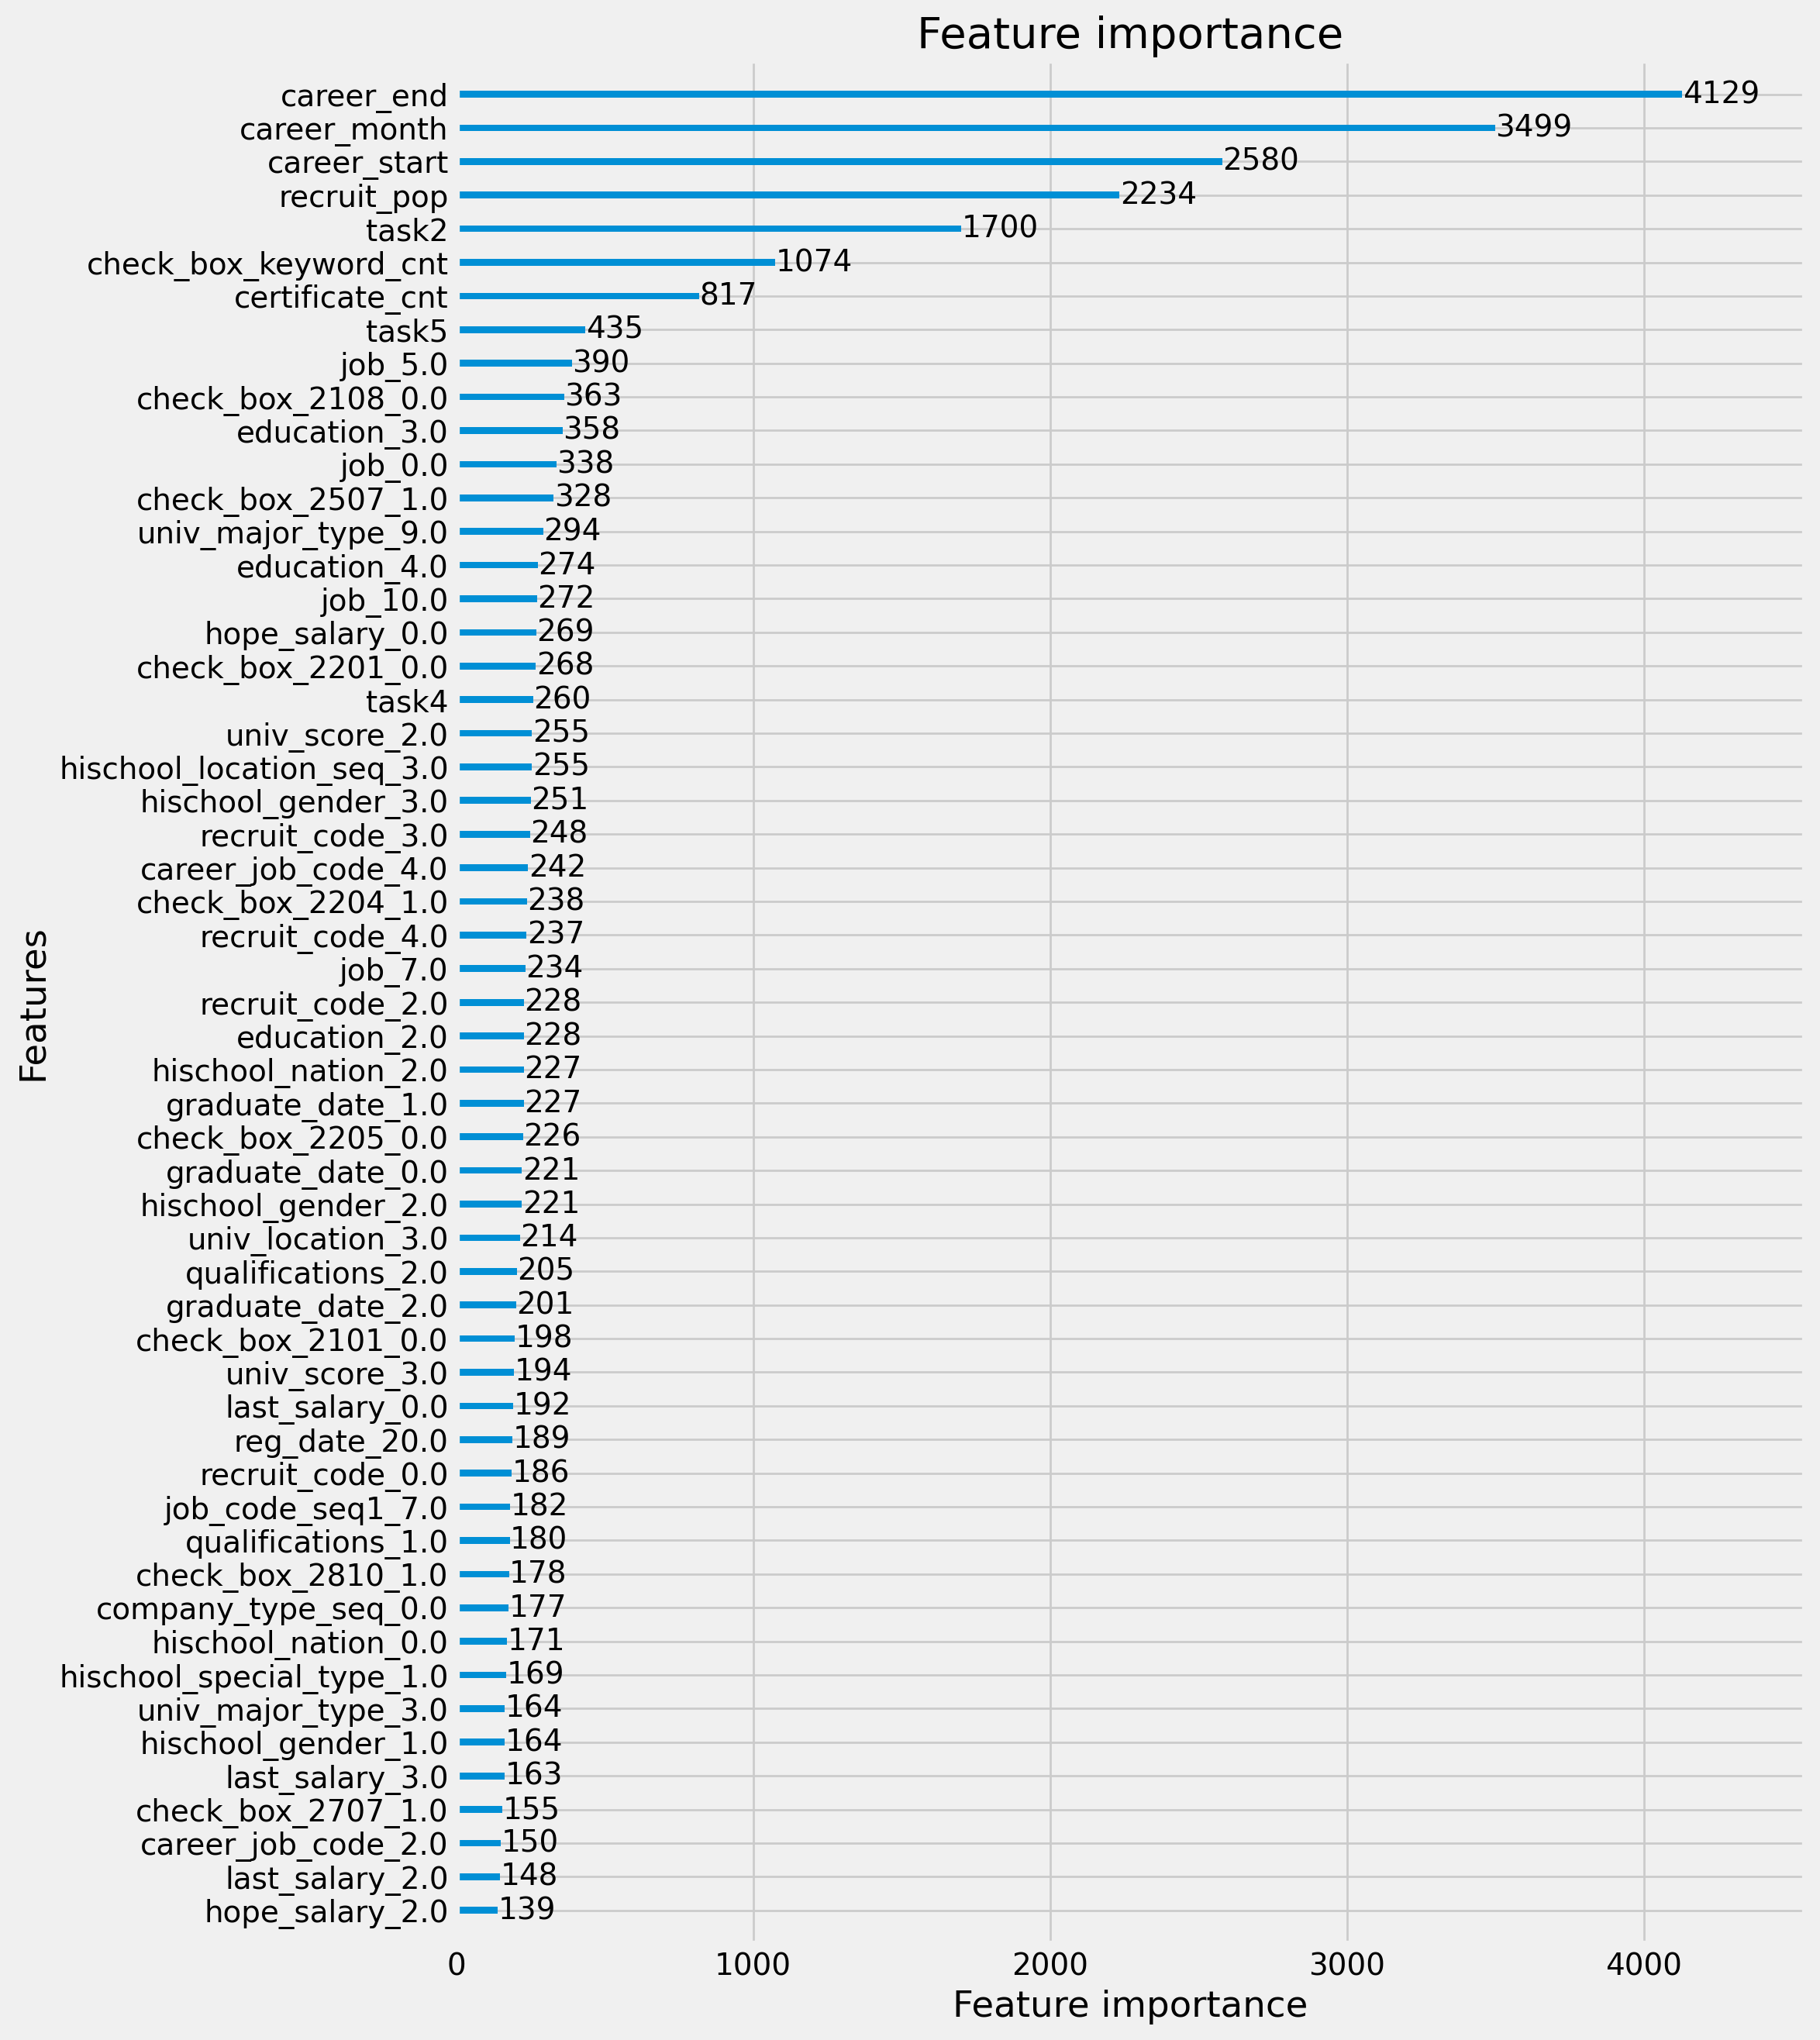

In [52]:
lgb.plot_importance(best_model, max_num_features=55,figsize=(10,15))

In [53]:
# # 전체 데이터셋의 모든 피처를 접두사 기준으로 그룹화
# all_features = X.columns.tolist()
# feature_groups = defaultdict(list)
# for feature in all_features:
#     prefix = feature.split('_')[0]
#     feature_groups[prefix].append(feature)

# feature_groups.keys()

In [54]:
# 베이스 피쳐 선택해주세요!

In [55]:
# # 초기 베이스 피처 세트를 선택
# base_feature_set_prefixes = ['hischool', 'univ', 'job', 'career', 'company']
# base_feature_set = []
# for prefix in base_feature_set_prefixes:
#     base_feature_set.extend(feature_groups[prefix])

# # 베이스 피처 세트에 포함되지 않는 피처 그룹을 찾음
# additional_feature_groups = {k: v for k, v in feature_groups.items() if k not in base_feature_set_prefixes}

# # AUC 점수와 피처 그룹 이름을 저장할 딕셔너리
# feature_group_auc_dict = {}

# # 각 추가 피처 그룹을 하나씩 추가하면서 평가
# for prefix, features in tqdm(additional_feature_groups.items(), desc='Evaluating additional feature groups'):
#     # 현재 피처 그룹 조합에 대한 데이터셋 준비
#     current_features = base_feature_set + features
#     X = df[current_features]
#     y = df["target"]

#     # 교차 검증을 위한 Stratified K-Fold 준비
#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     auc_scores = []  # 현재 피처 그룹 조합에 대한 AUC 점수를 저장할 리스트

#     # 교차 검증
#     for train_index, valid_index in skf.split(X, y):
#         tr_x, valid_x = X.iloc[train_index], X.iloc[valid_index]
#         tr_y, valid_y = y.iloc[train_index], y.iloc[valid_index]

#         # 모델 학습
#         best_model.fit(tr_x, tr_y)

#         # 예측 확률
#         valid_pred_proba = best_model.predict_proba(valid_x)[:, 1]

#         # AUC 점수 계산 및 저장
#         auc_score = roc_auc_score(valid_y, valid_pred_proba)
#         auc_scores.append(auc_score)

#     # 평균 AUC 점수 계산 및 딕셔너리에 저장
#     average_auc = np.mean(auc_scores)
#     feature_group_auc_dict[prefix] = average_auc  # 딕셔너리에 추가

# # 딕셔너리를 데이터프레임으로 변환
# feature_group_auc_df = pd.DataFrame(list(feature_group_auc_dict.items()), columns=['Feature Group', 'Average AUC'])

# # 데이터프레임을 CSV 파일로 저장
# feature_group_auc_df.to_csv('feature_group_auc_scores.csv', index=False)

In [56]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # AUC 점수를 기준으로 피처를 내림차순으로 정렬
# feature_group_auc_df = feature_group_auc_df.sort_values('Average AUC', ascending=False)

# # 그래프 크기 설정
# plt.figure(figsize=(10, 12))

# # 막대 그래프 그리기
# sns.barplot(x='Average AUC', y='Feature Group', data=feature_group_auc_df)

# # 그래프 타이틀 및 레이블 설정
# plt.title('Feature Importance based on AUC Score')
# plt.xlabel('Average AUC Score')
# plt.ylabel('Feature Group')

# # 그래프 표시
# plt.show()


In [57]:
# # 전체 데이터셋의 모든 피처를 접두사 기준으로 그룹화
# all_features = X.columns.tolist()
# feature_groups = defaultdict(list)
# for feature in all_features:
#     prefix = feature.split('_')[0]
#     feature_groups[prefix].append(feature)
# feature_groups.keys()

In [58]:
# # 초기 베이스 피처 세트를 선택
# base_feature_set_prefixes = ['hischool', 'univ', 'job', 'career', 'company']
# base_feature_set = []
# for prefix in base_feature_set_prefixes:
#     base_feature_set.extend(feature_groups[prefix])

# # 베이스 피처 세트에 포함되지 않는 피처 그룹을 찾음
# additional_feature_groups = {k: v for k, v in feature_groups.items() if k not in base_feature_set_prefixes}

# # AUC 점수와 피처 그룹 이름을 저장할 딕셔너리
# feature_group_auc_dict = {}

# # 랜덤으로 5개의 피처 그룹을 선택하여 평가
# random_feature_group_combinations = [random.sample(list(additional_feature_groups.keys()), 5) for _ in range(10)]

# for group_combination in tqdm(random_feature_group_combinations, desc='Evaluating random feature group combinations'):
#     # 현재 피처 그룹 조합에 대한 데이터셋 준비
#     current_features = base_feature_set + [feature for group in group_combination for feature in additional_feature_groups[group]]
#     X = df[current_features]
#     y = df["target"]

#     # 교차 검증을 위한 Stratified K-Fold 준비
#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     auc_scores = []  # 현재 피처 그룹 조합에 대한 AUC 점수를 저장할 리스트

#     # 교차 검증
#     for train_index, valid_index in skf.split(X, y):
#         tr_x, valid_x = X.iloc[train_index], X.iloc[valid_index]
#         tr_y, valid_y = y.iloc[train_index], y.iloc[valid_index]

#         # 모델 학습
#         best_model.fit(tr_x, tr_y)

#         # 예측 확률
#         valid_pred_proba = best_model.predict_proba(valid_x)[:, 1]

#         # AUC 점수 계산 및 저장
#         auc_score = roc_auc_score(valid_y, valid_pred_proba)
#         auc_scores.append(auc_score)

#     # 평균 AUC 점수 계산 및 딕셔너리에 저장
#     average_auc = np.mean(auc_scores)
#     feature_group_auc_dict[str(group_combination)] = average_auc  # 딕셔너리에 추가

# # 딕셔너리를 데이터프레임으로 변환
# feature_group_auc_df = pd.DataFrame(list(feature_group_auc_dict.items()), columns=['Feature Group Combination', 'Average AUC'])

# # 데이터프레임을 CSV 파일로 저장
# feature_group_auc_df.to_csv('random_feature_group_combination_auc_scores.csv', index=False)


In [59]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # AUC 점수를 기준으로 피처를 내림차순으로 정렬
# feature_group_auc_df = feature_group_auc_df.sort_values('Average AUC', ascending=False)

# # 그래프 크기 설정
# plt.figure(figsize=(10, 12))

# # 막대 그래프 그리기
# sns.barplot(x='Average AUC', y='Feature Group Combination', data=feature_group_auc_df)

# # 그래프 타이틀 및 레이블 설정
# plt.title('Feature Importance based on AUC Score')
# plt.xlabel('Average AUC Score')
# plt.ylabel('Feature Group')

# # 그래프 표시
# plt.show()


In [60]:
# # 피처 중요도 확인
# feature_importance = best_model.feature_importances_

# # 중요도가 가장 높은 순으로 피처 인덱스 정렬
# sorted_feature_indices = np.argsort(feature_importance)[::-1]

# # 피처 중요도를 그래프로 출력
# plt.figure(figsize=(10, 6))
# plt.bar(range(len(feature_importance)), feature_importance[sorted_feature_indices])
# plt.xticks(range(len(feature_importance)), [feature_names[idx] for idx in sorted_feature_indices], rotation=90)
# plt.xlabel('Feature Name')
# plt.ylabel('Feature Importance')
# plt.title('Feature Importance')
# plt.show()

In [61]:
#stop code (3번 진행 안되도록)

## SHAP

In [62]:
# explainer = shap.TreeExplainer(best_model) # 학습된 모델을 넣는다.
# shap_values = explainer.shap_values(X)

In [63]:
# shap_values[1].shape , X.shape

In [64]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[1],shap_values[1][-1,:],X.iloc[-1,:])

In [65]:
# shap.summary_plot(shap_values[1],X)

In [66]:
# shap.dependence_plot("age",shap_values[1],X,interaction_index=None)

In [67]:
# shap.dependence_plot("age",shap_values[1],X,interaction_index="auto")

In [68]:
# for col in X_te.columns:
#     shap.dependence_plot(col,shap_values[1],X)

# 3.각 resume_seq별로 전체 recruitment_seq의 확률 계산

In [69]:
# for user in tqdm(loaddata.user_pool):
#     # 2. 임시 데이터프레임 생성
#     _df_temp = pd.DataFrame({'resume_seq': [user] * len(recruitment)})

#     # 3. 전체 공고 seq를 붙임
#     _df_temp['recruitment_seq'] = list(loaddata.item_pool)
#     _df_temp.head()

#     # 4. 임시 데이터프레임에 feature들 merge. 이후 구직자, 공고 id 제거 및 모델 학습
#     _df_train = pd.merge(_df_temp, recruitment[recruitment_used_cols], on = 'recruitment_seq', how = 'left')
#     _df_train = pd.merge(_df_train, resume[resume_used_cols], on = 'resume_seq', how = 'left')
#     _df_train = _df_train.drop(columns = ['recruitment_seq', 'resume_seq'])


  0%|          | 0/8482 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [70]:
# all_recommendations = []

# for user in tqdm(loaddata.user_pool):
#     # 2. 임시 데이터프레임 생성
#     _df_temp = pd.DataFrame({'resume_seq': [user] * len(recruitment)})

#     # 3. 전체 공고 seq를 붙임
#     _df_temp['recruitment_seq'] = list(loaddata.item_pool)
#     _df_temp.head()

#     # 4. 임시 데이터프레임에 feature들 merge. 이후 구직자, 공고 id 제거 및 모델 학습
#     _df_train = pd.merge(_df_temp, recruitment[recruitment_used_cols], on = 'recruitment_seq', how = 'left')
#     _df_train = pd.merge(_df_train, resume[resume_used_cols], on = 'resume_seq', how = 'left')
#     _df_train = _df_train.drop(columns = ['recruitment_seq', 'resume_seq'])

#     # 5. 예측 확률 계산
#     pred_proba = best_model.predict_proba(_df_train)[:,1]

#     # 6. 임시 데이터프레임에 예측 확률 추가하고 상위로 정렬
#     _df_temp['target'] = pred_proba
#     _df_temp = _df_temp.sort_values(by='target', ascending=False)

#     # 7. 현재 구직자의 이미 지원한 공고 가져오기
#     already_applied_jobs = apply[apply['resume_seq'] == user]['recruitment_seq'].values

#     # 8. 임시 데이터프레임에서 이미 지원한 공고를 제거
#     _df_temp = _df_temp[~_df_temp['recruitment_seq'].isin(already_applied_jobs)]

#     # 10.  상위 5개 추천 (이미 지원한 공고를 제외한 상위 5개)
#     top_recommendations = _df_temp.head(5)

#     # 결과 출력 또는 활용
#     all_recommendations.append(top_recommendations)

# final_recommendations = pd.concat(all_recommendations, ignore_index=True)
# final_recommendations.shape

  0%|          | 0/8482 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# all_recommendations1 = []
# all_recommendations2 = []
# negatives_dict = dict(zip(loaddata.negatives['resume_seq'], loaddata.negatives['num_ng']))

# for user in tqdm(loaddata.user_pool):
#     num_ng = negatives_dict.get(user, 0)

#     # 2. 임시 데이터프레임 생성
#     _df_temp = pd.DataFrame({'resume_seq': [user] * len(recruitment)})

#     # 3. 전체 공고 seq를 붙임
#     _df_temp['recruitment_seq'] = list(loaddata.item_pool)
#     _df_temp.head()

#     # 4. 임시 데이터프레임에 feature들 merge. 이후 구직자, 공고 id 제거 및 모델 학습
#     _df_train = pd.merge(_df_temp, recruitment[recruitment_used_cols], on = 'recruitment_seq', how = 'left')
#     _df_train = pd.merge(_df_train, resume[resume_used_cols], on = 'resume_seq', how = 'left')
#     _df_train = _df_train.drop(columns = ['recruitment_seq', 'resume_seq'])

#     # 5. 예측 확률 계산
#     pred_proba = best_model.predict_proba(_df_train)[:,1]

#     # 6. 임시 데이터프레임에 예측 확률 추가하고 상위로 정렬
#     _df_temp['target'] = pred_proba
#     _df_temp = _df_temp.sort_values(by='target', ascending=False)

#     # 7. 현재 구직자의 이미 지원한 공고 가져오기
#     already_applied_jobs = apply[apply['resume_seq'] == user]['recruitment_seq'].values

#     # 8. 데이터 분리(이미 지원한과 그 외의 데이터)
#     _df_temp1 = _df_temp.head(num_ng*3) # 이미 지원한 개수만큼 (recall 자체 평가를 위함)
#     _df_temp2 = _df_temp[~_df_temp['recruitment_seq'].isin(already_applied_jobs)] # 그 외 데이터

#     # 9. Recall 평가를 위한 데이터셋 생성(이미 지원한 공고)
#     top_recommendations1 = _df_temp1

#     # 10. 상위 5개 추천 (이미 지원한 공고를 제외한 상위 5개)
#     top_recommendations2 = _df_temp2.head(5)

#     # 결과 출력 또는 활용
#     all_recommendations1.append(top_recommendations1)
#     all_recommendations2.append(top_recommendations2)

# final_recommendations1 = pd.concat(all_recommendations1, ignore_index=True)
# final_recommendations2 = pd.concat(all_recommendations2, ignore_index=True)

# final_recommendations1.shape, final_recommendations2.shape

In [80]:
# 이건 추천 메트릭스를 만들기 위함이다
all_recommendations = []
recommend_matix = pd.DataFrame(index=resume_all['resume_seq'], columns=list(recruit_all['recruitment_seq']))
recommend_matix=recommend_matix.fillna(0)
i=0
for user in tqdm(sorted(loaddata.user_pool)):
    # 2. 임시 데이터프레임 생성
    _df_temp = pd.DataFrame({'resume_seq': [user] * 100})
    # _df_temp = pd.DataFrame({'resume_seq': [user] * len(recruitment)})

    # 3. 해당 사용자에 대응하는 공고 seq를 가져와서 할당
    user_recommendations = recommendations.get(str(user), [])  # 사용자에 대응하는 추천 작업들
    _df_temp['recruitment_seq'] = user_recommendations[:500]  # 상위 500개 추천 작업 할당

    # 피쳐 데이터 결합(모델 예측 베이스)
    _df_train = pd.merge(_df_temp, recruitment[recruitment_used_cols], on='recruitment_seq', how='left')
    _df_train = pd.merge(_df_train, resume[resume_used_cols], on='resume_seq', how='left')
    _df_train = _df_train.drop(columns=['recruitment_seq', 'resume_seq'])



    # 4. 임시 데이터프레임에 feature들 merge. 이후 구직자, 공고 id 제거 및 모델 학습
    _df_train = pd.merge(_df_temp, recruitment[recruitment_used_cols], on = 'recruitment_seq', how = 'left')
    _df_train = pd.merge(_df_train, resume[resume_used_cols], on = 'resume_seq', how = 'left')
    # education 조건 안맞으면 drop함
    _df_train=_df_train.merge(resume_all[['resume_seq','degree']], on= 'resume_seq',how = 'left')
    _df_train=_df_train.merge(recruit_all[['recruitment_seq', 'education']], on= 'recruitment_seq',how = 'left')


    _df_train = _df_train.drop(columns = ['recruitment_seq', 'resume_seq'])

    _df_train.loc[_df_train['degree'] < _df_train['education']] = 0
    _df_train.drop(columns= ['degree','education'], inplace= True)


    # 5. 예측 확률 계산
    pred_proba = best_model.predict_proba(_df_train)[:,1]

    # 6. 임시 데이터프레임에 예측 확률 추가하고 상위로 정렬
    _df_temp['target'] = pred_proba
    _df_temp=_df_temp.sort_values(by='recruitment_seq')
    recommend_matix.loc[user,user_recommendations[:500]]=_df_temp['target'].values
    i= i+1
    if i ==0 :
        break




  0%|          | 0/8482 [00:00<?, ?it/s]

In [81]:
# 예제 DataFrame 생성

df = pd.DataFrame(recommend_matix)

# CSV 파일로 저장
df.to_csv('./recommend_matix2.csv', index=False)

In [82]:
# all_recommendations = []
# recommend_matix = pd.DataFrame(index=resume_all['resume_seq'], columns=list(recruit_all['recruitment_seq']))

# negatives_dict = dict(zip(loaddata.negatives['resume_seq'], loaddata.negatives['num_ng']))

# for user in tqdm(loaddata.user_pool):
#     num_ng = negatives_dict.get(user, 0)

#     # 2. 임시 데이터프레임 생성
#     _df_temp = pd.DataFrame({'resume_seq': [user] * 100})

#     # 3. 해당 사용자에 대응하는 공고 seq를 가져와서 할당
#     user_recommendations = recommendations.get(str(user), [])  # 사용자에 대응하는 추천 작업들
#     _df_temp['recruitment_seq'] = user_recommendations[:500]  # 상위 500개 추천 작업 할당

#     # 피쳐 데이터 결합(모델 예측 베이스)
#     _df_train = pd.merge(_df_temp, recruitment[recruitment_used_cols], on='recruitment_seq', how='left')
#     _df_train = pd.merge(_df_train, resume[resume_used_cols], on='resume_seq', how='left')
#     _df_train = _df_train.drop(columns=['recruitment_seq', 'resume_seq'])

#     # 5. 예측 확률 계산
#     pred_proba = best_model.predict_proba(_df_train)[:,1]

#     # 6. 임시 데이터프레임에 예측 확률 추가하고 상위로 정렬
#     _df_temp['target'] = pred_proba
#     _df_temp = _df_temp.sort_values(by='target', ascending=False)

#     # 7. 현재 구직자의 이미 지원한 공고 가져오기
#     already_applied_jobs = apply[apply['resume_seq'] == user]['recruitment_seq'].values

#     # 8. 데이터 분리(이미 지원한 것과 그 외의 데이터)
#     _df_temp1 = _df_temp.head(num_ng) # 이미 지원한 개수만큼 (recall 자체 평가를 위함)
#     _df_temp2 = _df_temp[~_df_temp['recruitment_seq'].isin(already_applied_jobs)] # 그 외 데이터

#     # 9. Recall 평가를 위한 데이터셋 생성(이미 지원한 공고)
#     top_recommendations1 = _df_temp1

#     # 10. 상위 5개 추천 (이미 지원한 공고를 제외한 상위 5개)
#     top_recommendations2 = _df_temp2.head(5)

#     # 결과 출력 또는 활용
#     all_recommendations1.append(top_recommendations1)
#     all_recommendations2.append(top_recommendations2)

# final_recommendations1 = pd.concat(all_recommendations1, ignore_index=True)
# final_recommendations2 = pd.concat(all_recommendations2, ignore_index=True)

# final_recommendations1.shape, final_recommendations2.shape

In [83]:
final_recommendations1.to_csv("res.csv")

NameError: name 'final_recommendations1' is not defined

In [ ]:
final_recommendations1 = final_recommendations1.sort_values(by='resume_seq', ascending=True)
final_recommendations2 = final_recommendations2.sort_values(by='resume_seq', ascending=True)

In [ ]:
final_recommendations1

In [ ]:
final_recommendations2.drop(columns='target',inplace=True)

In [ ]:
a=final_recommendations2.copy()
a.reset_index(drop=True)

In [ ]:
default_path

In [ ]:
a.to_csv(default_path+'result'+rusult_filename+'.csv', index=False) # 제출용 파일

In [ ]:
final_recommendations1 = final_recommendations1.sort_values(by='target', ascending=False)

#4.Recall@5를 통해 평가

In [ ]:
final_recommendations1_dict = final_recommendations1.groupby('resume_seq').apply(lambda x: x['recruitment_seq'].tolist()).to_dict()
apply_dict = apply.groupby('resume_seq').apply(lambda x: x['recruitment_seq'].tolist()).to_dict()

In [ ]:
individual_recalls = []
for user, item in apply_dict.items():
    if user in final_recommendations1_dict:
        correct_matches = len(set(apply_dict[user]) & set(final_recommendations1_dict[user]))
        individual_recall = correct_matches / len(item)
        individual_recalls.append(individual_recall)
print(np.mean(individual_recalls))